# Projection of the risk free curve and recalibration inside OSEM

The purpose of this workbook is to showcase the calibration methodology inside OSEM. The key to the calibration is the Smith Wilson algorithm commonly used in insurance. This algorithm allows a continious approximation of arbitrary maturities based on a subset of available maturities. This example is split onto 3 parts. 

 - The first part shows how the necessary parameters and curves are imported from input files. 
 - Second part shows how the curves are generated and the Smith-Wilson calibrations derived. 
 - The last part shows how the saved calibration can be used to derive an the discount rates for any maturity.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [58]:
from ImportData import import_SWEiopa
from CurvesClass import Curves

## Importing files

The parameters and the current risk free curve are provided as input:

 - Parameters.csv; Parameters related to the run 
 - EIOPA_param_file.csv; Assumed yield curve at modelling date and relevant maturities
 - EIOPA_curves_file.csv; Parameters related to the EIOPA time 0 calibration
 
 
 The exact location of the EIOPA files is encoded in the Parameters input file. 

In [59]:
paramfile = pd.read_csv("Input\Parameters.csv", index_col="Parameter")

The location of the two EIOPA files are:

In [60]:
selected_param_file = paramfile["Value"].loc["EIOPA_param_file"]
selected_curves_file = paramfile["Value"].loc["EIOPA_curves_file"]

The risk free curve belongs to the following country:

In [61]:
country = paramfile["Value"].loc["country"]

Import all necessary parameters:

In [62]:
[maturities_country, curve_country, extra_param, Qb] = import_SWEiopa(selected_param_file, selected_curves_file, country)

## Preparation and treatment of the curves

The OSEM does multiple steps in order to make it easier for OSEM to access discount curves at any point in time and for arbitrary maturities. All steps are performed and saved within the Curves class.

### The curves class

The curve class object contains all the data necessary to run the model.

In [63]:
# ultimate forward rate
ufr = extra_param["UFR"]/100

# Numeric precision of the optimisation
precision = float(paramfile["Value"].loc["Precision"])

# Targeted distance between the extrapolated curve and the ultimate forward rate at the convergence point
tau = float(paramfile["Value"].loc["Tau"])# 1 basis point

modelling_date = paramfile.loc["Modelling_Date"]

# Number of projection years
n_years = int(paramfile.loc["n_proj_years"][0])

In [64]:
curves = Curves(ufr, precision, tau, modelling_date, country)

After the Curves class is initiated, there are a series if calibrations that needs to be performed.

 - Saving of the input term structure
 - Calculation of the forward rates
 - Projection of the forward spot rates
 - Calculation of the Smith-Wilson calibrations for each period

### Save the input term structure

SetObservedTermStructure sets the liquid maturities and the coresponding yields to the m_obs and r_obs property of the Curves class. 

In [65]:
curves.SetObservedTermStructure(maturity_vec=curve_country.index.tolist(), yield_vec=curve_country.values)

### Calculate 1 year forward rates

Using the time 0 spot curve provided as input, the yearly forward rates can be calculated from the annually reported yield curve
$$
fw_{EIOPA,1} = y_1
$$

otherwise:

$$
fw_{EIOPA,t} = \frac{(1 + y_t)^{-t}}{(1 + y_{t-1})^{-(t-1)}} 
$$

The forward rates will be used to calculate forward spot curves.

In [66]:
curves.CalcFwdRates()

### Forward yield curve

The forward yield curve can be calculated by using the 1-year forward rates from the suitable moment onwards. The spot yield curve is calculated for each projection period. For the projection period $i$, the yield curve can be calculated as:

$$
y^i_{t-i} = \prod_i^t\big(1+fw_{EIOPA}(t)\big)^{\frac{1}{t-i}}
$$

In [67]:
curves.ProjectForwardRate(n_years)

## Calibrate Smith-Wilson on each yield curve

Each forward spot curve is used to calibrate the SW algorithm. This calibration can then be used to generate yield corves of arbitrary maturities. The calibration is split on two parts. First one calibrates the curve at time 0

### Calibration at time 0

In [68]:
NameOfYear = "Yield_year_0"
NameOfYear_2 = "Maturities_year_0"
NameOfYear_3 = "Calibration_year_0"
NameOfYear_4 = "Alpha_year_0"

r_obs = np.transpose(np.array(curves.r_obs[NameOfYear])) # Obtain the yield curve
m_obs = np.transpose(np.array(curves.m_obs[NameOfYear_2])) # Obtain the maturities curve

# Calculate the calibration parameter alpha 
alphaoptimized = [curves.BisectionAlpha(0.05, 0.5, m_obs, r_obs, curves.ufr, curves.tau, curves.precision, 1000)]

# Save the calibration parameter alpha
curves.alpha[NameOfYear_4] = alphaoptimized

b_calibrated = curves.SWCalibrate(r_obs, m_obs, curves.ufr, curves.alpha[NameOfYear_4][0])
curves.b[NameOfYear_3] = b_calibrated

### Calibration at all future times

In [69]:
for iYear in range(1, n_years):
    ProjYear = iYear
    NameOfYear = "Yield_year_" + str(ProjYear)
    NameOfYear_2 = "Maturities_year_" + str(ProjYear)
    NameOfYear_3 = "Calibration_year_" + str(ProjYear)
    NameOfYear_4 = "Alpha_year_" + str(ProjYear)
    
    r_obs = np.transpose(np.array(curves.r_obs[NameOfYear]))[:-ProjYear] # Obtain the yield curve
    m_obs = np.transpose(np.array(curves.m_obs[NameOfYear_2]))[:-ProjYear]

    alphaoptimized = [curves.BisectionAlpha(0.05, 0.5, m_obs, r_obs, curves.ufr, curves.tau, curves.precision, 1000)]
    curves.alpha[NameOfYear_4] = alphaoptimized

    b_calibrated = curves.SWCalibrate(r_obs, m_obs, curves.ufr, curves.alpha[NameOfYear_4][0])
    b_calibrated = np.append(b_calibrated, np.repeat(np.nan, ProjYear))
    
    curves.b[NameOfYear_3] = b_calibrated
    

## Example 1

Is the yield curve equal to the curve used for the calibration?

In [70]:
r_obs_est = curves.SWExtrapolate(m_obs, m_obs, curves.b[NameOfYear_3][:-(ProjYear)], curves.ufr, curves.alpha[NameOfYear_4][0])

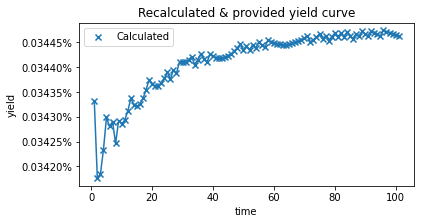

In [71]:
fig, ax1 = plt.subplots(1, 1)
ax1.scatter(m_obs, r_obs, label="Calculated", marker="x")
ax1.plot(m_obs, r_obs_est)
ax1.set_ylabel("yield")
ax1.set_title('Recalculated & provided yield curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()

## Example 2

The future yield curve for arbitrary maturities.

Assuming the algorithm is processing the year 3. A hypothetical asset has a cash flow at year fractions:
$ \{0.7, 1.2, 2.1, 3.543\} $

To make it possible to calculate the present value, the coresponding dicount rates are calculated:


In [72]:
ModellingYear = 3
maturity_name = "Maturities_year_" + str(ModellingYear)
calibration_name = "Calibration_year_" + str(ModellingYear)
alpha_name = "Alpha_year_" + str(ModellingYear)

# The maturities for which we are looking the discount yields
desired_mat = np.array([0.7, 1.2, 2.1, 3.543])

In [73]:
calib_b = curves.b[calibration_name][:-ModellingYear].values

In [74]:
calib_maturities = curves.m_obs[maturity_name][:-ModellingYear].values

In [75]:
calib_alpha = curves.alpha[alpha_name][0]

In [76]:
result = curves.SWExtrapolate(desired_mat, calib_maturities, calib_b, curves.ufr, calib_alpha)

The required yields are:

In [77]:
display(result)

array([0.02618662, 0.026155  , 0.02616982, 0.02642073])